# BOLD, non-BOLD, and TE-dependence with tedana

```{important}
This chapter should differentiate itself from Signal_Decay by focusing on the application of {eq}`monoexponential_decay`
to decompositions, rather than raw signal compared between active and inactive states.

We may want to describe adaptive masking, data whitening, the model fit metrics, and post-processing methods (e.g., MIR)
in this page as well.
```

```{important}
The general flow of this chapter should be:

1.  Explain the monoexponential decay equation, but primarily reference back to Signal_Decay.
2.  Walk through optimal combination and adaptive masking somewhere around here.
3.  Describe why multi-echo denoising can't be done directly to the raw signal and why ICA is necessary.
    1.  This mean talking about noise, really, and why the FIT method (volume-wise T2*/S0 estimation)
        is generally considered too noisy for practical application.
    2.  Walk through TEDPCA as well.
4.  The TE-(in)dependence models.
5.  Apply the models to a simulated component, as well as multiple real components.
    1.  Show model fit for different components.
6.  Compare optimally combined, denoised, and high-kappa data.
7.  Describe post-processing methods, like minimum image regression and tedana's version of global signal regression.
```

This notebook uses simulated T2*/S0 manipulations to show how TE-dependence is leveraged to denoise multi-echo data.

The equation for how signal is dependent on changes in S0 and T2*:

```{math}
:label: monoexponential_decay
S(t, TE_k) = \bar{S}(TE_k) * (1 + \frac{{\Delta}{S_0}(t)}{\bar{S}_0} - {\Delta}{R_2^*}(t)*TE_k)
```

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from book_utils import compute_te_dependence_statistics, predict_bold_signal
from myst_nb import glue
from nilearn.glm import first_level
from repo2data.repo2data import Repo2Data
from scipy import signal, stats

sns.set_style("whitegrid")

# Install the data if running locally, or point to cached data if running on neurolibre
DATA_REQ_FILE = os.path.join("../binder/data_requirement.json")

# Download data
repo2data = Repo2Data(DATA_REQ_FILE)
data_path = repo2data.install()
data_path = os.path.abspath(data_path[0])

out_dir = os.path.join(data_path, "te-dependence")
os.makedirs(out_dir, exist_ok=True)

---- repo2data starting ----
/opt/hostedtoolcache/Python/3.10.17/x64/lib/python3.10/site-packages/repo2data
Config from file :
../binder/data_requirement.json
Destination:
./../data/multi-echo-data-analysis

Info : ./../data/multi-echo-data-analysis already downloaded


In [2]:
# Simulate data
# For a nice, smooth curve
echo_times = np.arange(0, 201, 1)

n_echoes = len(echo_times)
pal = sns.color_palette("cubehelix", 8)

mean_s0 = 16000
mean_t2s = 30

frac = 0.2
s02 = mean_s0 + (mean_s0 * frac)
t2s2 = mean_t2s + (mean_t2s * frac)

mean_sig = np.squeeze(predict_bold_signal(echo_times, mean_s0, mean_t2s))

# Signal with fluctuating S0
sig2 = np.squeeze(predict_bold_signal(echo_times, s02, mean_t2s))
d_sig2 = sig2 - mean_sig
dt_sig2 = d_sig2 / ((sig2 + mean_sig) / 2.0)

# Signal with fluctuating T2*
sig3 = np.squeeze(predict_bold_signal(echo_times, mean_s0, t2s2))
d_sig3 = sig3 - mean_sig
dt_sig3 = d_sig3 / ((sig3 + mean_sig) / 2.0)

## Plot simulations of BOLD and non-BOLD signals as a function of echo time

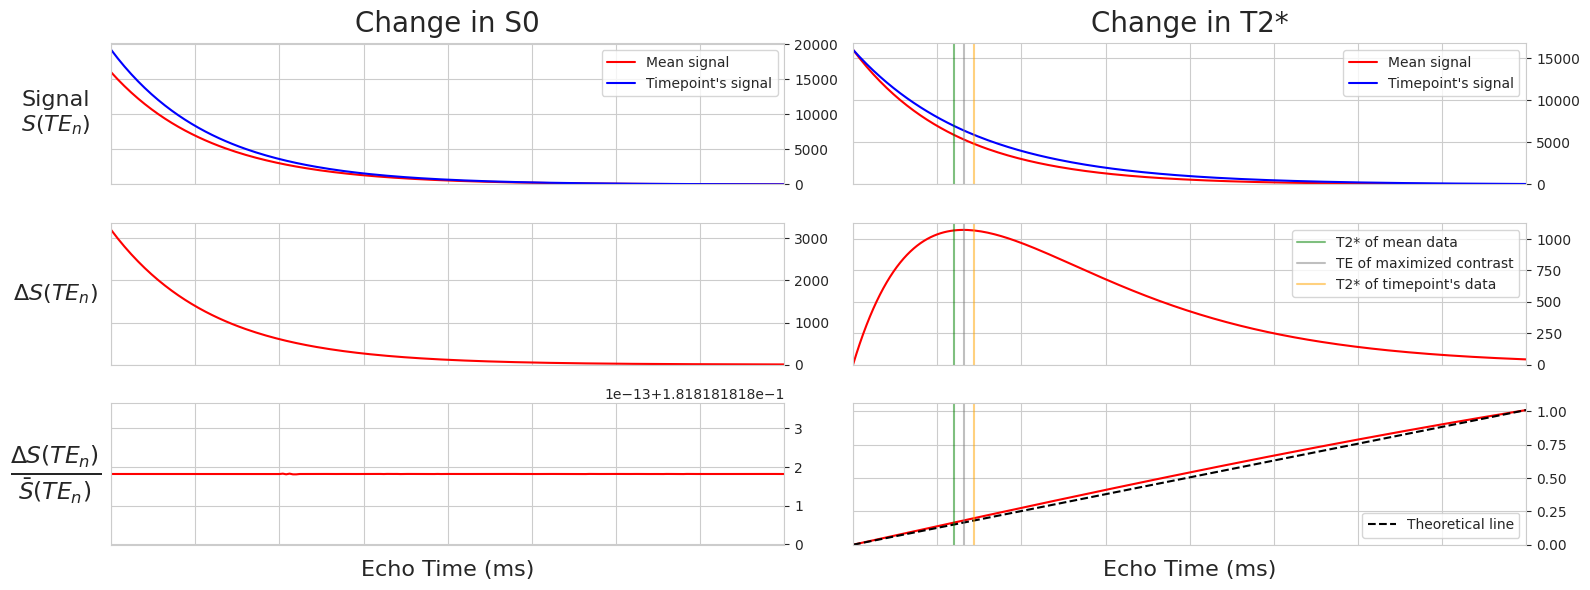

In [3]:
# change s0
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(16, 6))
axes[0, 0].yaxis.tick_right()
axes[0, 0].set_xticklabels([])
axes[0, 0].plot(echo_times, mean_sig, "red", label="Mean signal")
axes[0, 0].plot(echo_times, sig2, "blue", label="Timepoint's signal")
axes[0, 0].set_ylim(0)
axes[0, 0].set_title("Change in S0", fontsize=20, y=1.02)
axes[0, 0].set_ylabel(
    "Signal\n$S(TE_n)$", fontsize=16, rotation=0, labelpad=40, va="center"
)
leg = axes[0, 0].legend()

axes[1, 0].yaxis.tick_right()
axes[1, 0].set_xticklabels([])
axes[1, 0].plot(echo_times, d_sig2, "red")
axes[1, 0].set_ylim(0)
axes[1, 0].set_ylabel(
    "${\\Delta}S(TE_n)$", fontsize=16, rotation=0, labelpad=40, va="center"
)

# No slope, intercept at delta(S0)/mean(S0)
axes[2, 0].yaxis.tick_right()
axes[2, 0].plot(echo_times, dt_sig2, "red")
axes[2, 0].set_ylabel(
    "$\\frac{{\\Delta}S(TE_n)}{\\bar{S}(TE_n)}$",
    fontsize=24,
    rotation=0,
    labelpad=40,
    va="center",
)
axes[2, 0].set_xlabel("Echo Time (ms)", fontsize=16)

# change t2s
# max diff is between orig and new T2*, but is definitely not mean
max_diff_te = echo_times[d_sig3 == np.max(d_sig3)][0]

axes[0, 1].yaxis.tick_right()
axes[0, 1].set_xticklabels([])
axes[0, 1].plot(echo_times, mean_sig, "red", label="Mean signal")
axes[0, 1].plot(echo_times, sig3, "blue", label="Timepoint's signal")
axes[0, 1].set_ylim(0)
axes[0, 1].set_title("Change in T2*", fontsize=20, y=1.02)

# Plot important echo times
axes[0, 1].axvline(mean_t2s, color="green", alpha=0.5)
axes[0, 1].axvline(max_diff_te, color="gray", alpha=0.5)
axes[0, 1].axvline(t2s2, color="orange", alpha=0.5)
leg = axes[0, 1].legend()

axes[1, 1].yaxis.tick_right()
axes[1, 1].set_xticklabels([])
axes[1, 1].plot(echo_times, d_sig3, "red")
axes[1, 1].set_ylim(0)

# Plot important echo times
axes[1, 1].axvline(mean_t2s, label="T2* of mean data", color="green", alpha=0.5)
axes[1, 1].axvline(
    max_diff_te, label="TE of maximized contrast", color="gray", alpha=0.5
)
axes[1, 1].axvline(t2s2, label="T2* of timepoint's data", color="orange", alpha=0.5)
leg = axes[1, 1].legend()

pred_slope = (dt_sig3[-1] - dt_sig3[0]) / (echo_times[-1] - echo_times[0])
pred_int = (pred_slope * echo_times[-1]) - dt_sig3[-1]
pred_max = pred_slope * echo_times[-1]

axes[2, 1].yaxis.tick_right()
axes[2, 1].plot(echo_times, dt_sig3, "red")
axes[2, 1].plot(
    [0, echo_times[-1]],
    [pred_int, pred_max],
    "black",
    linestyle="--",
    label="Theoretical line",
)
axes[2, 1].set_ylim(0, None)
axes[2, 1].set_xlim(0, np.max(echo_times))
# axes[2, 1].set_xticks(echo_times)
axes[2, 1].set_xlabel("Echo Time (ms)", fontsize=16)
axes[2, 1].axvline(max_diff_te, color="gray", alpha=0.5)
axes[2, 1].axvline(mean_t2s, color="green", alpha=0.5)
axes[2, 1].axvline(t2s2, color="orange", alpha=0.5)
leg = axes[2, 1].legend()

fig.tight_layout()
glue("fig_bold_nonbold_simulations", fig, display=False)

```{glue:figure} fig_bold_nonbold_simulations
:name: fig_bold_nonbold_simulations
:align: center

Simulations of BOLD and non-BOLD signals as a function of echo time
```

## Make design matrices

For TEDPCA and TEDICA, we use regression to get parameter estimates (PEs; not beta values)
for component time-series against echo-specific data, and substitute those PEs for ${\bar{S}(TE_k)}$.
At some point, I would like to dig into why those parameter estimates are equivalent to ${\bar{S}(TE_k)}$ for our purposes.

## TE-independence model

```{math}
:label: te_independence_model1
\frac{{\Delta}S(TE_k)}{\bar{S(TE_k)}} = \frac{{\Delta}S_0}{S_0}
```

```{math}
:label: te_independence_model2
{\Delta}S(TE_k) = {\bar{S}(TE_k)}\frac{{\Delta}S_0}{S_0}
```

$\frac{{\Delta}S_0}{S_0}$ is a scalar (i.e., doesn't change with TE), so we ignore that,
which means we only use ${\bar{S}(TE_k)}$ (mean echo-wise signal).

Thus,

```{math}
:label: te_independence_model3
{\Delta}S(TE_k) = {\bar{S}(TE_k)} * X
```

and for TEDPCA/TEDICA,

```{math}
:label: te_independence_model4
PE(TE_k) = {\bar{S}(TE_k)} * X
```

Lastly, we fit X to the data and evaluate model fit.

## TE-dependence model

```{math}
:label: te_dependence_model1
\frac{{\Delta}S(TE_k)}{\bar{S}(TE_k)} = -{\Delta}{R_2^*}*TE_k
```

```{math}
:label: te_dependence_model2
{\Delta}S(TE_k) = {\bar{S}(TE_k)} * -{\Delta}{R_2^*}*TE_k
```

$-{\Delta}{R_2^*}$ is a scalar, so we ignore it,
which means we only use ${\bar{S}(TE_k)}$ (mean echo-wise-signal) and $TE_k$ (echo time in milliseconds).

Thus,

```{math}
:label: te_dependence_model3
{\Delta}S(TE_k) = {\bar{S}(TE_k)}*TE_k * X
```

and for TEDPCA/TEDICA,

```{math}
:label: te_dependence_model4
PE(TE_k) = {\bar{S}(TE_k)}*TE_k * X
```

Lastly, we fit X to the data and evaluate model fit.

In [4]:
X1 = (mean_sig)[:, None]  # Model 1

# NOTE: T2* is unnecessary for this, since it's a scalar
X2 = ((echo_times * mean_sig) / mean_t2s)[:, None]  # Model 2

## Fitted curves for S0-perturbed signal

The predicted curve for the S0 model matches the real curve perfectly!

In [5]:
B = d_sig2[:, None]  # (E x S)
alpha = (np.abs(B) ** 2).sum(axis=0)

# S0 Model
coeffs_S0 = (B * X1).sum(axis=0) / (X1 ** 2).sum(axis=0)
pred_S0 = X1 * np.tile(coeffs_S0, (n_echoes, 1))
SSE_S0 = (B - pred_S0) ** 2
SSE_S0 = SSE_S0.sum(axis=0)  # (S,) prediction error map
F_S0 = (alpha - SSE_S0) * (n_echoes - 1) / (SSE_S0)
pred_S0_2 = pred_S0.copy()

# R2 Model
coeffs_R2 = (B * X2).sum(axis=0) / (X2 ** 2).sum(axis=0)
pred_R2 = X2 * np.tile(coeffs_R2, (n_echoes, 1))
SSE_R2 = (B - pred_R2) ** 2
SSE_R2 = SSE_R2.sum(axis=0)
F_R2 = (alpha - SSE_R2) * (n_echoes - 1) / (SSE_R2)
pred_R2_2 = pred_R2.copy()

print("Rho: {}".format(F_S0[0]))
print("Kappa: {}".format(F_R2[0]))
print()

# Parameter estimate * mean S0 gives delta(S0)
print("Real delta S0: {}".format(s02 - mean_s0))
print("Delta S0 from results: {}".format(coeffs_S0[0] * mean_s0))

Rho: 4.467769094175043e+32
Kappa: 187.14447409804956

Real delta S0: 3200.0
Delta S0 from results: 3200.000000000006


## Fitted curves for R2*-perturbed signal

For some reason, the predicted curve for the R2 model doesn't match the real signal curve.
What's with this mismatch?

It seems like the mismatch increases as the difference between the fluctuating volume's R2 and the mean R2 increase.
The fitted curve seems to actually match the mean signal, not the perturbed signal!

In [6]:
B = d_sig3[:, None]  # (E x S)
alpha = (np.abs(B) ** 2).sum(axis=0)

# S0 Model
coeffs_S0 = (B * X1).sum(axis=0) / (X1 ** 2).sum(axis=0)
pred_S0 = X1 * np.tile(coeffs_S0, (n_echoes, 1))
SSE_S0 = (B - pred_S0) ** 2
SSE_S0 = SSE_S0.sum(axis=0)  # (S,) prediction error map
F_S0 = (alpha - SSE_S0) * (n_echoes - 1) / (SSE_S0)
pred_S0_3 = pred_S0.copy()

# R2 Model
coeffs_R2 = (B * X2).sum(axis=0) / (X2 ** 2).sum(axis=0)
pred_R2 = X2 * np.tile(coeffs_R2, (n_echoes, 1))
SSE_R2 = (B - pred_R2) ** 2
SSE_R2 = SSE_R2.sum(axis=0)
F_R2 = (alpha - SSE_R2) * (n_echoes - 1) / (SSE_R2)
pred_R2_3 = pred_R2.copy()

print("Rho: {}".format(F_S0[0]))
print("Kappa: {}".format(F_R2[0]))

Rho: 156.88794104788448
Kappa: 31513.966302911744


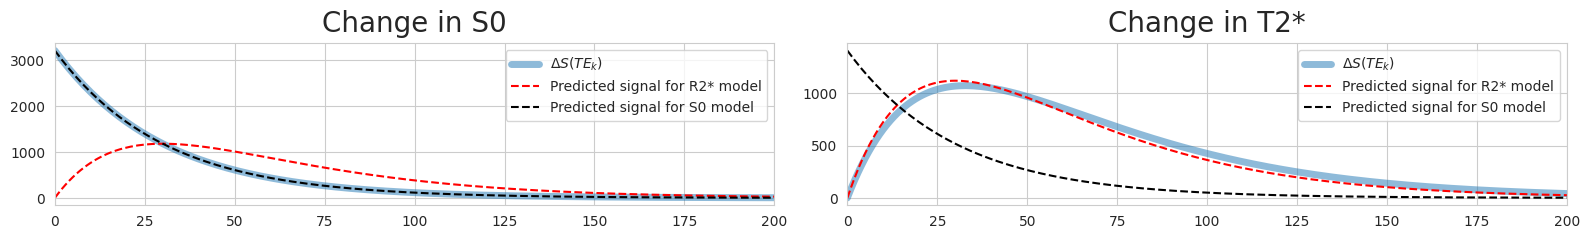

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 2.5))

axes[0].set_title("Change in S0", fontsize=20, y=1.02)
axes[0].plot(echo_times, d_sig2, label="${\\Delta}S(TE_k)$", linewidth=5, alpha=0.5)
axes[0].plot(
    echo_times,
    np.squeeze(pred_R2_2),
    label="Predicted signal for R2* model",
    linestyle="--",
    color="red",
)
axes[0].plot(
    echo_times,
    np.squeeze(pred_S0_2),
    label="Predicted signal for S0 model",
    linestyle="--",
    color="black",
)
axes[0].set_xlim(0, np.max(echo_times))
legend = axes[0].legend()

axes[1].set_title("Change in T2*", fontsize=20, y=1.02)
axes[1].plot(echo_times, d_sig3, label="${\\Delta}S(TE_k)$", linewidth=5, alpha=0.5)
axes[1].plot(
    echo_times,
    np.squeeze(pred_R2_3),
    label="Predicted signal for R2* model",
    linestyle="--",
    color="red",
)
axes[1].plot(
    echo_times,
    np.squeeze(pred_S0_3),
    label="Predicted signal for S0 model",
    linestyle="--",
    color="black",
)
axes[1].set_xlim(0, np.max(echo_times))
legend = axes[1].legend()

fig.tight_layout()
glue("fig_fitted_r2_curves", fig, display=False)

```{glue:figure} fig_fitted_r2_curves
:name: fig_fitted_r2_curves
:align: center

Fitted curves for R2*-perturbed signal
```

In [8]:
# lstsq gives same result as model fit method by kundu, which is great to see
x, res, rank, sing = np.linalg.lstsq(X2, B, rcond=None)
print(x[0])
print(coeffs_R2)

[0.19006077]
[0.19006077]


## Now let's apply this approach to components

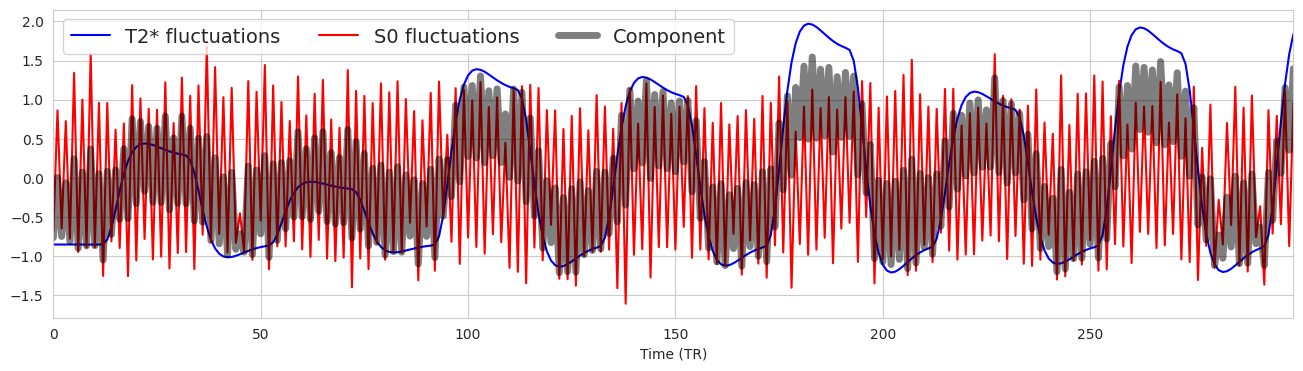

In [9]:
# Simulate data
# We'll convolve with HRF just for smoothness
hrf = first_level.spm_hrf(1, oversampling=1)

n_trs = 300

frac = 0.05  # 5% PSC
mean_t2s = 30
t2s_std = mean_t2s * frac
mean_s0 = 16000
s0_std = mean_s0 * frac

# simulate the T2*/S0 time series
n_chunks = 10
scales = np.random.random(n_chunks) * 3
t2s_ts = []
for section in range(n_chunks):
    ts = np.hstack((np.zeros(10), np.ones(20), np.zeros(10)))
    ts *= scales[section]
    t2s_ts.append(ts)

t2s_ts = np.hstack(t2s_ts)[:n_trs + 20]
t2s_ts = signal.convolve(t2s_ts, hrf)[:n_trs]
t2s_ts *= t2s_std / np.std(t2s_ts)
t2s_ts += mean_t2s - np.mean(t2s_ts)

s0_ts = np.random.randint(0, 2, n_trs).astype(float)
s0_ts -= 0.5
s0_ts *= np.random.normal(loc=1, scale=0.25, size=n_trs)
s0_ts = np.sort(s0_ts)
first_half = s0_ts[:n_trs // 2]
second_half = s0_ts[n_trs // 2:]
s0_ts = np.zeros(n_trs)
np.random.shuffle(first_half)
np.random.shuffle(second_half)
s0_ts[::2] = first_half
s0_ts[1::2] = second_half
# s0_ts = signal.convolve(s0_ts, hrf)[20 : n_trs + 20]
s0_ts *= s0_std / np.std(s0_ts)
s0_ts += mean_s0 - np.mean(s0_ts)

# Constant T2*/S0 time series
mean_s0_ts = np.ones(n_trs) * mean_s0
mean_t2s_ts = np.ones(n_trs) * mean_t2s

# Simulate signal for each echo time
t2s_signal = predict_bold_signal(echo_times, mean_s0_ts, t2s_ts)
s0_signal = predict_bold_signal(echo_times, s0_ts, mean_t2s_ts)
multiecho_signal = predict_bold_signal(echo_times, s0_ts, t2s_ts)

# Normalize to get component time series
t2s_ts_z = stats.zscore(t2s_ts)
s0_ts_z = stats.zscore(s0_ts)
p = 0.5  # proportion for combination
component = (p * t2s_ts_z) + ((1 - p) * s0_ts_z)

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(t2s_ts_z, label="T2* fluctuations", color="blue")
ax.plot(s0_ts_z, label="S0 fluctuations", color="red")
ax.plot(component, label="Component", color="black", alpha=0.5, linewidth=5)
ax.set_xlim(0, n_trs - 1)
ax.set_xlabel("Time (TR)")
leg = ax.legend(fontsize=14, ncol=3)
glue("fig_component_curves", fig, display=False)

```{glue:figure} fig_component_curves
:name: fig_component_curves
:align: center

Now let's apply this approach to components
```

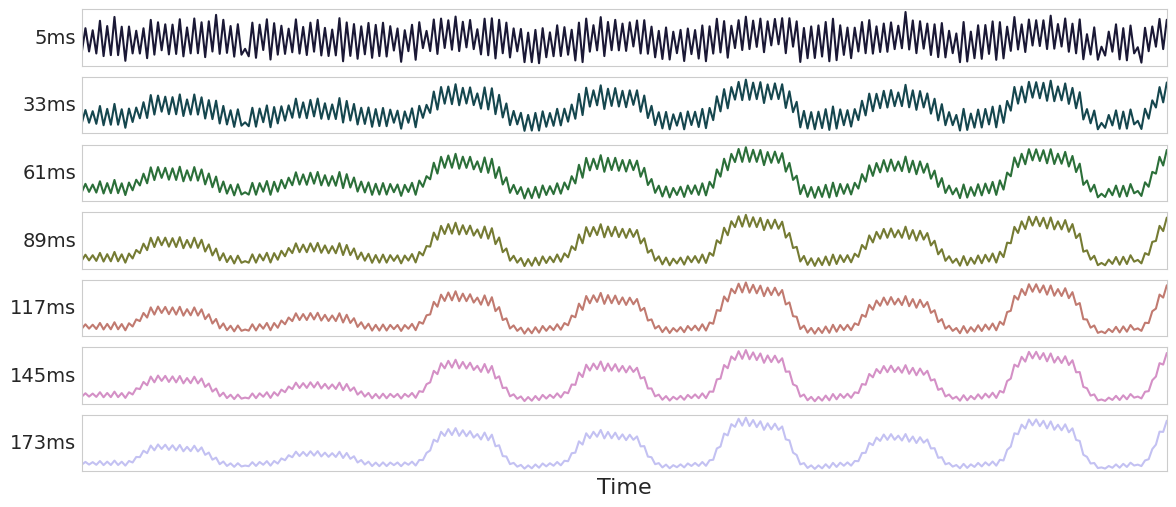

In [10]:
interval = int(np.floor(n_echoes / 7))
echoes_to_plot = list(range(5, n_echoes, interval))
fig, axes = plt.subplots(
    len(echoes_to_plot), sharex=True, sharey=False, figsize=(14, 6)
)

for i_echo, echo in enumerate(echoes_to_plot):
    axes[i_echo].plot(multiecho_signal[echo, :], color=pal[i_echo])
    axes[i_echo].set_ylabel(
        "{0}ms".format(echo_times[echo]),
        rotation=0,
        va="center",
        ha="right",
        fontsize=14,
    )
    axes[i_echo].set_yticks([])
    axes[i_echo].set_xticks([])

axes[-1].set_xlabel("Time", fontsize=16)
axes[-1].set_xlim(0, n_trs - 1)
glue("fig_component_curves_2", fig, display=False)

```{glue:figure} fig_component_curves_2
:name: fig_component_curves_2
:align: center

Now let's apply this approach to components again.
```

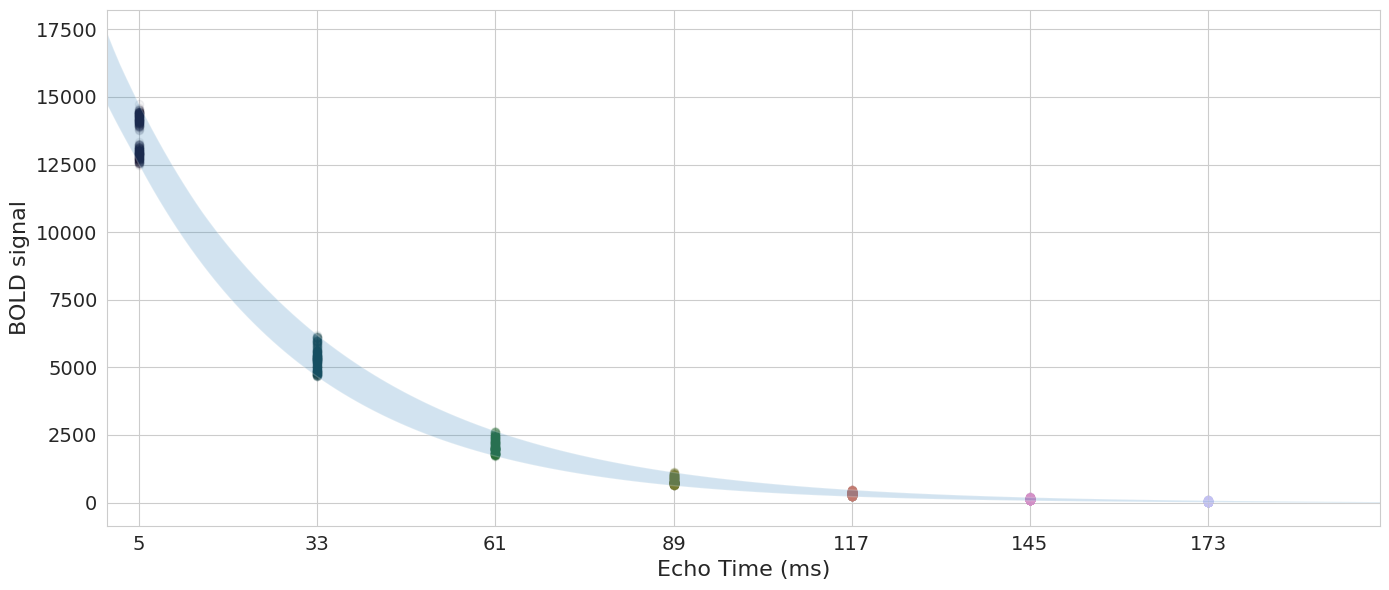

In [11]:
interval = int(np.floor(n_echoes / 7))
echoes_to_plot = list(range(5, n_echoes, interval))
fig, ax = plt.subplots(figsize=(14, 6))
for i_echo, echo in enumerate(echoes_to_plot):
    rep_echo_times = np.ones(n_trs) * echo
    ax.scatter(rep_echo_times, multiecho_signal[echo, :], alpha=0.05, color=pal[i_echo])

max_signal = np.max(multiecho_signal, axis=1)
min_signal = np.min(multiecho_signal, axis=1)
ax.fill_between(echo_times, max_signal, min_signal, alpha=0.2)

ax.set_ylabel("BOLD signal", fontsize=16)
ax.set_xlabel("Echo Time (ms)", fontsize=16)
ax.set_xticks(echoes_to_plot)
ax.set_xlim(0, np.max(echo_times))
ax.tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()
glue("fig_component_curves_3", fig, display=False)

```{glue:figure} fig_component_curves_3
:name: fig_component_curves_3
:align: center

Now let's apply this approach to components again.
```

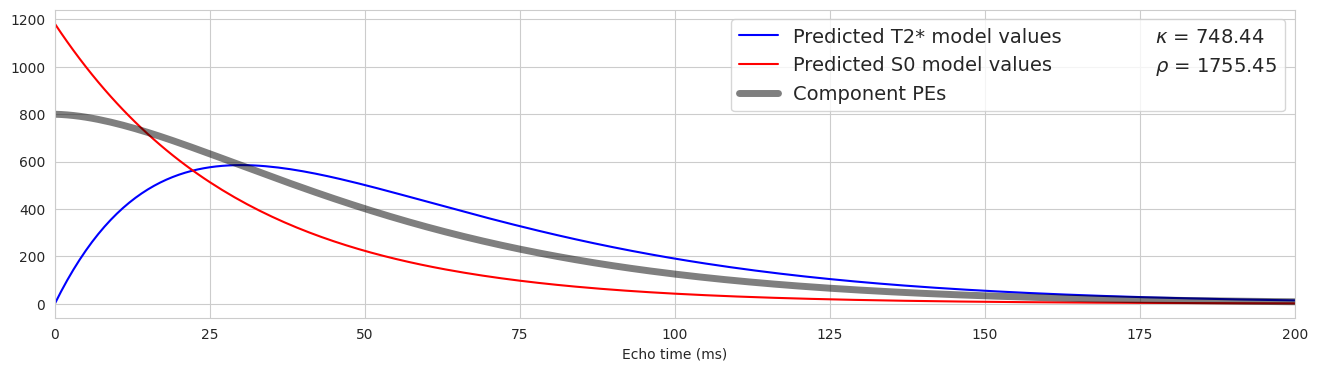

In [12]:
fig, ax = plt.subplots(figsize=(16, 4))

# Add a constant term to the array
comp_X = np.hstack((component[:, None], np.ones((component.shape[0], 1))))
pes, _, _, _ = np.linalg.lstsq(comp_X, multiecho_signal.T, rcond=None)
pes = pes[0, :]

F_S0, F_R2, pred_S0, pred_R2 = compute_te_dependence_statistics(
    multiecho_signal, pes, echo_times
)
ax.plot(echo_times, pred_R2, label="Predicted T2* model values", c="blue")
ax.plot(echo_times, pred_S0, label="Predicted S0 model values", c="red")
ax.plot(echo_times, pes, label="Component PEs", alpha=0.5, linewidth=5, c="black")
ax.plot(echo_times, pred_R2, label=r"$\kappa$ = {:.02f}".format(F_R2[0]), alpha=0)
ax.plot(echo_times, pred_S0, label=r"$\rho$ = {:.02f}".format(F_S0[0]), alpha=0)
ax.set_xlim(0, np.max(echo_times))
ax.set_xlabel("Echo time (ms)")
leg = ax.legend(fontsize=14, ncol=2)
glue("fig_component_curves_4", fig, display=False)

```{glue:figure} fig_component_curves_4
:name: fig_component_curves_4
:align: center

Now let's apply this approach to components again.
```

```{prf:algorithm} Minimum image regression
:label: minimum-image-regression
<!-- Written by Taylor Salo, Jessica Bartley, and Elizabeth DuPre -->

**Inputs**

- $\mathbf{O}$ is the matrix of optimally combined (OC) data, of shape $v \times t$,
where $v$ is the number of voxels in the brain mask and $t$ is the number of timepoints in the scan.
- $\mathbf{M}$ is the mixing matrix from the ICA decomposition, of shape $c \times t$, where $c$ is the number of components.
- $W$ is the set of indices of all components in $\mathbf{M}$: $W = \{1, 2, 3, ..., c\}$
- $N$ is the set of indices of all non-ignored components (i.e., all accepted or BOLD-like, and rejected or non-BOLD components) in
  $\mathbf{M}$: $N \in \mathbb{N}^k \text{ s.t } 1 \leq k \leq c, N \subseteq W$
- $A$ is the set of indices of all accepted (i.e., BOLD-like) components in $\mathbf{M}$:
  $A \in \mathbb{N}^l \text{ s.t } 1 \leq l \leq k, A \subseteq N$

**Outputs**

- Multi-echo denoised data without the T1-like effect, referred to as $\mathbf{D}$ or MEDN+MIR.
- Multi-echo BOLD-like data without the T1-like effect, referred to as $\mathbf{H}$ or MEHK+MIR.
- ICA mixing matrix with the T1-like effect removed from component time series ($\mathbf{K}$).
- Map of the T1-like effect ($\mathbf{m}$)

**Algorithm**

1.  The voxel-wise means ($\mathbf{\overline{O}} \in \mathbb{R}^{v}$) and standard deviations
    ($\mathbf{\sigma_{O}} \in \mathbb{R}^{v}$) of the optimally combined data are computed over time.
2.  The optimally combined data are z-normalized over time ($\mathbf{O_z} \in \mathbb{R}^{v \times t}$).
3.  The normalized optimally combined data matrix ($\mathbf{O_z}$) is regressed on the ICA mixing matrix
    ($\mathbf{M} \in \mathbb{R}^{c \times t}$) to construct component-wise parameter estimate maps
    ($\mathbf{B} \in \mathbb{R}^{v \times c}$).

    <!-- no intercept included, because unnecessary and data are normalized. -->
    $$
        \mathbf{O_{z}} = \mathbf{B} \mathbf{M} + \mathbf{\epsilon}, \enspace \mathbf{\epsilon} \in \mathbb{R}^{v \times t}
    $$

4.  $N$ is used to select rows from the mixing matrix $\mathbf{M}$ and columns from the parameter estimate matrix $\mathbf{B}$
    that correspond to non-ignored (i.e., accepted and rejected) components, forming reduced matrices $\mathbf{M}_N$ and $\mathbf{B}_N$.
    The normalized time series matrix for the combined ignored components and variance left unexplained by the ICA decomposition is then
    computed by subtracting the scalar product of the non-ignored beta weight and mixing matrices from the normalized OC data time series
    ($\mathbf{O_{z}}$).
    The result is referred to as the normalized residuals time series matrix ($\mathbf{R} \in \mathbb{R}^{v \times t}$).

    $$
        \mathbf{R} = \mathbf{O_{z}} - \mathbf{B}_N \mathbf{M}_N, \enspace \mathbf{B}_N \in \mathbb{R}^{v \times |N|},
        \enspace \mathbf{M}_N \in \mathbb{R}^{|N| \times t}
    $$

5.  We can likewise construct the normalized time series of BOLD-like components ($\mathbf{P} \in \mathbb{R}^{v \times t}$) by
    multiplying similarly reduced parameter estimate and mixing matrices composed of only the columns and rows, respectively,
    that are associated with the accepted components indexed in $A$.
    The resulting time series matrix is similar to the time series matrix referred to elsewhere in the manuscript as
    multi-echo high-Kappa (MEHK), with the exception that the component time series have been normalized prior to reconstruction.

    $$
        \mathbf{P} = \mathbf{B}_A \mathbf{M}_A, \enspace \mathbf{B}_A \in \mathbb{R}^{v \times |A|},
        \enspace \mathbf{M}_A \in \mathbb{R}^{|A| \times t}
    $$

6.  The map of the T1-like effect ($\mathbf{m} \in \mathbb{R}^{v}$) is constructed by taking the minimum across timepoints
    from the normalized MEHK time series ($\mathbf{P}$) and then mean-centering across brain voxels.
    Let $J = \{1, ..., t\}$ denote the indices of the columns of matrix $\mathbf{P}$, and let $p_{ij}$ denote the value of the
    element $\mathbf{P}[i,j]$.

    <!-- adapted from https://math.stackexchange.com/a/871689 -->
    $$
        \mathbf{q_{i}} = \min_{j\in{J}}p_{ij} \quad \forall  i = 1,...,v
    $$

    $$
        \mathbf{m} = \mathbf{q} - \mathbf{\overline{q}}, \enspace \mathbf{q} \in \mathbb{R}^{v}
    $$

7.  The standardized optimally combined time series matrix ($\mathbf{O_z}$) is regressed on the T1-like effect map
    ($\mathbf{m}$) to estimate the volume-wise global signal time series ($\mathbf{g} \in \mathbb{R}^t$).

    $$
        \mathbf{O_{z}} = \mathbf{m} \otimes \mathbf{g} + \mathbf{\epsilon}, \enspace \mathbf{\epsilon} \in \mathbb{R}^{v \times t}
    $$

    Where $\otimes$ is the outer product.

8.  The normalized BOLD time series matrix ($\mathbf{P}$) is then regressed on this global signal time series ($\mathbf{g}$)
    in order to estimate a global signal map ($\mathbf{s} \in \mathbb{R}^v$) and the normalized BOLD time series matrix without
    the T1-like effect ($\mathbf{E} \in \mathbb{R}^{v \times t}$).

    $$
        \mathbf{P} = \mathbf{g} \otimes \mathbf{s} + \mathbf{E}
    $$

9.  The time series matrix of BOLD-like components without the T1-like effect (MEHK+MIR, $\mathbf{H} \in \mathbb{R}^{v \times t}$),
    scaled to match the original OC time series matrix, is constructed by multiplying each column of $\mathbf{E}$ by the vector
    $\mathbf{\sigma_{O}}$.

    $$
        \mathbf{H} = \mathbf{E} \circ
        \underbrace{
            \pmatrix{
                \mathbf{{\sigma_{O}}_1} & \cdots & \mathbf{{\sigma_{O}}_1}\\
                \vdots & \vdots & \vdots \\
                \mathbf{{\sigma_{O}}_v} & \cdots & \mathbf{{\sigma_{O}}_v}\\
            }
        }_{t}
    $$

    Where $\circ$ is the [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices))
    for element-wise multiplication of two matrices.

10. The ICA-denoised time series without the T1-like effect (MEDN+MIR, $\mathbf{D} \in \mathbb{R}^{v \times t}$)
    is constructed by adding the residuals time series ($\mathbf{R}$) to the normalized BOLD time series ($\mathbf{E}$),
    multiplying each column of the result by the vector $\sigma_{O}$, and adding back in the voxel-wise mean of the OC time series
    ($\mathbf{\overline{O}}$).

    $$
        \mathbf{D} = \mathbf{\overline{O}} + (\mathbf{E} + \mathbf{R}) \circ
        \underbrace{
            \pmatrix{
                \mathbf{{\sigma_{O}}_1} & \cdots & \mathbf{{\sigma_{O}}_1}\\
                \vdots & \vdots & \vdots \\
                \mathbf{{\sigma_{O}}_v} & \cdots & \mathbf{{\sigma_{O}}_v}\\
            }
        }_{t}
    $$

11. The T1c-corrected ICA mixing matrix is then derived by regressing the global signal time series $\mathbf{g}$ from
    each component's time series. Let $\mathbf{Q}$ be the associated parameter estimate matrix
    ($\mathbf{Q} \in \mathbb{R}^{c \times t}$).

    $$
        \mathbf{M} = \mathbf{Q}\mathbf{g} + \mathbf{K}
    $$

    $$
        \mathbf{K} = \mathbf{M} - \mathbf{Q}\mathbf{g}
    $$
```